## Model1. 구조변경
- 실습에서는 nn.RNN 을 사용하였다면, 이번 과제에서는 nn.LSTM을 사용함.
    - LSTM은 Long short-term memory RNN 이다.
    - LSTM은 기본 RNN의 gredient vanishing 문제를 해결하기 위해 제안된 모델이다. 
    - gredient vanishing은 기울기소실로, 앞쪽의 gredient가 너무 작아져 무시되는 문제점이다. 이를 memory에 저장해 사용함으로써 기존 RNN의 문제를 해결하는 방법이 LSTM이다.
    
    
- 실습 때 사용한 RNN model의 Test Loss : 0.01412
- 과제에서 사용한 LSTM model 의 Test Loss : 0.00846

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import random

import pandas as pd

In [2]:
# GPU/CPU setting
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

cpu


In [3]:
# import dataset
import yfinance as yf

aapl = yf.download('AAPL', start='2019-01-01', end='2023-12-31')
aapl
# 시작가, 최고가, 최저가, 종가, 장외가, 주식거래량 (6가지 정보)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,38.722500,39.712502,38.557499,39.480000,37.793781,148158800
2019-01-03,35.994999,36.430000,35.500000,35.547501,34.029240,365248800
2019-01-04,36.132500,37.137501,35.950001,37.064999,35.481930,234428400
2019-01-07,37.174999,37.207500,36.474998,36.982498,35.402939,219111200
2019-01-08,37.389999,37.955002,37.130001,37.687500,36.077831,164101200
...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.091385,37122800
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.542831,28919300
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.642548,48087700


<Axes: xlabel='Date'>

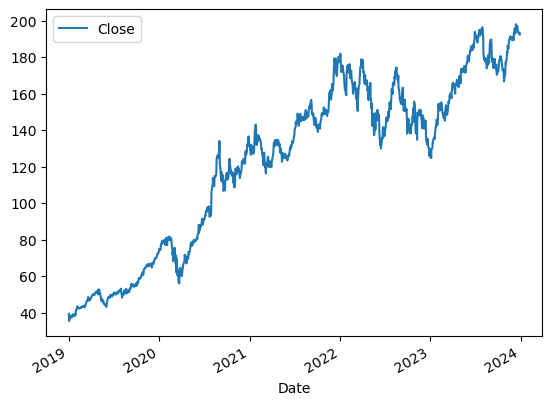

In [4]:
# data가 dataFrame 형태로 되어있고,
# 그 중에서 close price만 가져옴.

df_aapl = pd.DataFrame(aapl['Close'])
df_aapl.plot()

In [5]:
# data preprocessing
# model의 입출력으로 사용하기 위해 처리하는 단계

from sklearn.preprocessing import MinMaxScaler

data_aapl = df_aapl.values
scaler = MinMaxScaler(feature_range=(0,1)) # 0~1의 값으로 scaling
data_aapl = scaler.fit_transform(data_aapl)

# 데이터간의 관계가 존재하기 때문에 다른 모델처럼 임의로 data를 나눠 train과 test에 사용하는 것이 아닌
# 기간을 나눠 train, test data로 사용
# 이번 실습에서는 5년치 데이터 중 4년치로 학습한 후 1년치의 예측이 잘 되는지로 확인
train_ratio = 0.8
split = int(train_ratio * len(data_aapl))
aapl_train = data_aapl[:split, :]
aapl_test = data_aapl[split:, :]

print(aapl_train.shape)
print(aapl_test.shape)

(1006, 1)
(252, 1)


In [6]:
# 10일동안의 종가 변화를 보고 1일의 종가를 예측
# 즉, sequence_length는 이전 몇개의 data를 보고 예측을 할거냐 결정
sequence_length = 10

x_train, y_train = [], []
for i in range(sequence_length, len(aapl_train)):
    # window sliding 형태로 구성 (1일씩 이동)
    x_train.append(aapl_train[i-sequence_length:i, 0])
    y_train.append(aapl_train[i, 0])
    
x_test, y_test = [], []
for i in range(sequence_length, len(aapl_test)):
    x_test.append(aapl_test[i-sequence_length:i, 0])
    y_test.append(aapl_test[i, 0])

# demension을 맞춘 후 최종 FloatTensor로 변환
x_train = np.array(x_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train = torch.FloatTensor(x_train)
y_train = np.array(y_train)
y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_train = torch.FloatTensor(y_train)

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test = torch.FloatTensor(x_test)
y_test = np.array(y_test)
y_test = np.reshape(y_test, (y_test.shape[0], 1))
y_test = torch.FloatTensor(y_test)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

torch.Size([996, 10, 1]) torch.Size([996, 1]) torch.Size([242, 10, 1]) torch.Size([242, 1])


In [7]:
# Batch generation
batch_size = 20

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length
        self.num_layers = num_layers
        self.device = device
        # batch_first : batch index를 앞에 둘거냐에 대한 opt
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid())
        
    def forward(self, x):
        # h0 : hidden state를 저장하는 Tensor (3차원)
        h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
        out, _ = self.lstm(x, (h0, h0))
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        
        return out

In [9]:
# create model
input_size = 1
num_layers = 2
hidden_size = 5

model = LSTM(input_size=input_size, hidden_size=hidden_size, sequence_length=sequence_length, num_layers=num_layers, device=device).to(device)
model

LSTM(
  (lstm): LSTM(1, 5, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=50, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [10]:
# Setting Hyperparameters
num_epochs = 200
learning_rate = 0.01

criterion = nn.MSELoss() # regression에서 사용되는 loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# model train
loss_list = []

for epoch_num in range(num_epochs):
    average_cost = 0
    
    for batch_idx, (x_data, y_label) in enumerate(train_loader):
        num_of_mini_batch = len(train_loader)
        x_data = x_data.to(device)
        label = y_label.to(device)
        
        optimizer.zero_grad()
        y_predict = model(x_data)
        loss = criterion(y_predict, label)
        loss.backward()
        optimizer.step()
        
        average_cost = average_cost + (loss.item() / num_of_mini_batch)
        loss_list.append(list)
        
    print("Epoch {} Loss {:.5f}".format((epoch_num + 1), average_cost))

Epoch 1 Loss 0.06339
Epoch 2 Loss 0.11420
Epoch 3 Loss 0.08639
Epoch 4 Loss 0.07456
Epoch 5 Loss 0.07217
Epoch 6 Loss 0.06875
Epoch 7 Loss 0.05564
Epoch 8 Loss 0.02575
Epoch 9 Loss 0.01699
Epoch 10 Loss 0.01656
Epoch 11 Loss 0.01222
Epoch 12 Loss 0.01108
Epoch 13 Loss 0.00924
Epoch 14 Loss 0.00666
Epoch 15 Loss 0.00600
Epoch 16 Loss 0.00620
Epoch 17 Loss 0.00585
Epoch 18 Loss 0.00531
Epoch 19 Loss 0.00483
Epoch 20 Loss 0.00437
Epoch 21 Loss 0.00391
Epoch 22 Loss 0.00342
Epoch 23 Loss 0.00288
Epoch 24 Loss 0.00238
Epoch 25 Loss 0.00233
Epoch 26 Loss 0.00242
Epoch 27 Loss 0.00246
Epoch 28 Loss 0.00245
Epoch 29 Loss 0.00246
Epoch 30 Loss 0.00246
Epoch 31 Loss 0.00243
Epoch 32 Loss 0.00240
Epoch 33 Loss 0.00236
Epoch 34 Loss 0.00231
Epoch 35 Loss 0.00226
Epoch 36 Loss 0.00223
Epoch 37 Loss 0.00220
Epoch 38 Loss 0.00219
Epoch 39 Loss 0.00218
Epoch 40 Loss 0.00217
Epoch 41 Loss 0.00216
Epoch 42 Loss 0.00215
Epoch 43 Loss 0.00214
Epoch 44 Loss 0.00213
Epoch 45 Loss 0.00211
Epoch 46 Loss 0.002

In [12]:
# validation
with torch.no_grad():
    num_total_data = 0
    correct = 0
    for batch_idx, (data, labels) in enumerate(test_loader):
        num_of_mini_batch = len(test_loader)
        
        data = data.to(device)
        labels = labels.to(device)
        outputs = model(data)
        loss = criterion(outputs, labels)
        
        average_cost = average_cost + (loss.item() / num_of_mini_batch)
        loss_list.append(loss)
    
print("Test Loss {:.5f}".format(average_cost))

Test Loss 0.00182


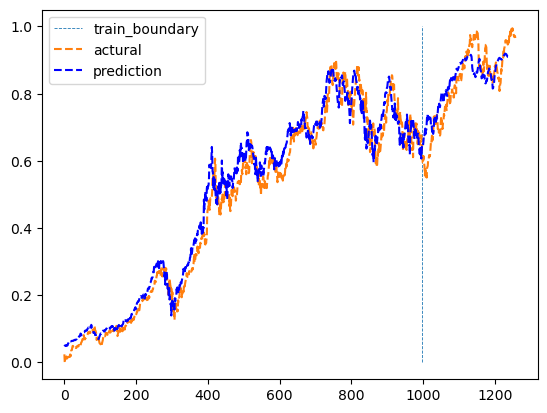

In [13]:
# visualization (plot)
with torch.no_grad():
    train_pred = []
    test_pred = []
    
    for batch_idx, (x_data, y_label) in enumerate(train_loader):
        x_data = x_data.to(device)
        label = y_label.to(device)
        y_predict = model(x_data)
        train_pred += y_predict.cpu().numpy().tolist()
        
    for batch_idx, (x_data, y_label) in enumerate(test_loader):
        x_data = x_data.to(device)
        label = y_label.to(device)
        y_predict = model(x_data)
        test_pred += y_predict.cpu().numpy().tolist()
        
total = train_pred + test_pred
plt.figure()
plt.plot(np.ones(100)*len(train_pred), np.linspace(0, 1, 100), '--', linewidth=0.6)
plt.plot(data_aapl, '--')
plt.plot(total, 'b--')
plt.legend(['train_boundary', 'actural', 'prediction'])
plt.show()

## Model2. input data 변경
- 실습에서는 apple의 주가예측을 진행했지만, 이번 과제는 Nvidia의 주가예측을 진행함.
- model 구조는 첫번째 모델로 사용한 LSTM을 동일하게 사용했으며, 예측에 사용한 data는 Close_price가 아닌 High_price로 예측을 진행함.
- 과제코드를 작성하면서 Close_price로도 예측해보고, High_price로도 예측을 진행했을 때 Test Loss가 각각 약 0.07, 0.05로 나왔다.
- 마지막 결과 plot을 보면 test data에 대해 절반정도는 거의 일치하지만 끝부분이 제대로 예측되지 않는 것을 확인할 수 있다.

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import random

import pandas as pd

In [15]:
# GPU/CPU setting
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

cpu


In [16]:
# import dataset
import yfinance as yf

aapl = yf.download('NVDA', start='2019-01-01', end='2023-12-31')
aapl
# 시작가, 최고가, 최저가, 종가, 장외가, 주식거래량 (6가지 정보)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,32.660000,34.619999,32.512501,34.055000,33.788891,50875200
2019-01-03,33.447498,33.790001,31.922501,31.997499,31.747467,70555200
2019-01-04,32.735001,34.432499,32.424999,34.047501,33.781448,58562000
2019-01-07,34.625000,36.222500,34.107498,35.849998,35.569866,70916000
2019-01-08,36.672501,36.695000,34.224998,34.957500,34.684345,78601600
...,...,...,...,...,...,...
2023-12-22,491.950012,493.829987,484.670013,488.299988,488.277069,25213900
2023-12-26,489.679993,496.000000,489.600006,492.790009,492.766907,24420000
2023-12-27,495.109985,496.799988,490.850006,494.170013,494.146820,23364800


<Axes: xlabel='Date'>

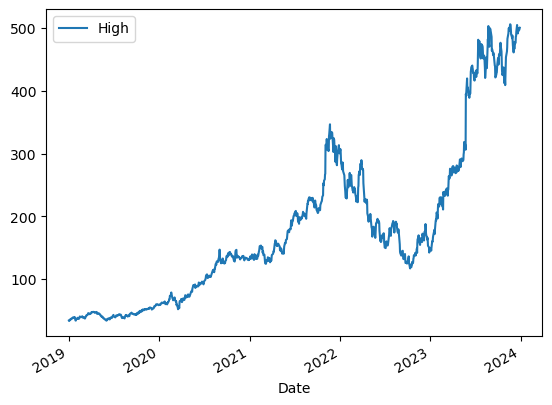

In [17]:
# data가 dataFrame 형태로 되어있고,
# 그 중에서 close price만 가져옴.

df_aapl = pd.DataFrame(aapl['High'])
df_aapl.plot()

In [18]:
# data preprocessing
# model의 입출력으로 사용하기 위해 처리하는 단계

from sklearn.preprocessing import MinMaxScaler

data_aapl = df_aapl.values
scaler = MinMaxScaler(feature_range=(0,1)) # 0~1의 값으로 scaling
data_aapl = scaler.fit_transform(data_aapl)

# 데이터간의 관계가 존재하기 때문에 다른 모델처럼 임의로 data를 나눠 train과 test에 사용하는 것이 아닌
# 기간을 나눠 train, test data로 사용
# 이번 실습에서는 5년치 데이터 중 4년치로 학습한 후 1년치의 예측이 잘 되는지로 확인
train_ratio = 0.8
split = int(train_ratio * len(data_aapl))
aapl_train = data_aapl[:split, :]
aapl_test = data_aapl[split:, :]

print(aapl_train.shape)
print(aapl_test.shape)

(1006, 1)
(252, 1)


In [19]:
# 10일동안의 종가 변화를 보고 1일의 종가를 예측
# 즉, sequence_length는 이전 몇개의 data를 보고 예측을 할거냐 결정
sequence_length = 10

x_train, y_train = [], []
for i in range(sequence_length, len(aapl_train)):
    # window sliding 형태로 구성 (1일씩 이동)
    x_train.append(aapl_train[i-sequence_length:i, 0])
    y_train.append(aapl_train[i, 0])
    
x_test, y_test = [], []
for i in range(sequence_length, len(aapl_test)):
    x_test.append(aapl_test[i-sequence_length:i, 0])
    y_test.append(aapl_test[i, 0])

# demension을 맞춘 후 최종 FloatTensor로 변환
x_train = np.array(x_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train = torch.FloatTensor(x_train)
y_train = np.array(y_train)
y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_train = torch.FloatTensor(y_train)

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test = torch.FloatTensor(x_test)
y_test = np.array(y_test)
y_test = np.reshape(y_test, (y_test.shape[0], 1))
y_test = torch.FloatTensor(y_test)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

torch.Size([996, 10, 1]) torch.Size([996, 1]) torch.Size([242, 10, 1]) torch.Size([242, 1])


In [20]:
# Batch generation
batch_size = 20

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
# model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length
        self.num_layers = num_layers
        self.device = device
        # batch_first : batch index를 앞에 둘거냐에 대한 opt
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid())
        
    def forward(self, x):
        # h0 : hidden state를 저장하는 Tensor (3차원)
        h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
        out, _ = self.lstm(x, (h0, h0))
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        
        return out

In [22]:
# create model
input_size = 1
num_layers = 2
hidden_size = 5

model = LSTM(input_size=input_size, hidden_size=hidden_size, sequence_length=sequence_length, num_layers=num_layers, device=device).to(device)
model

LSTM(
  (lstm): LSTM(1, 5, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=50, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [23]:
# Setting Hyperparameters
num_epochs = 200
learning_rate = 0.01

criterion = nn.MSELoss() # regression에서 사용되는 loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [24]:
# model train
loss_list = []

for epoch_num in range(num_epochs):
    average_cost = 0
    
    for batch_idx, (x_data, y_label) in enumerate(train_loader):
        num_of_mini_batch = len(train_loader)
        x_data = x_data.to(device)
        label = y_label.to(device)
        
        optimizer.zero_grad()
        y_predict = model(x_data)
        loss = criterion(y_predict, label)
        loss.backward()
        optimizer.step()
        
        average_cost = average_cost + (loss.item() / num_of_mini_batch)
        loss_list.append(list)
        
    print("Epoch {} Loss {:.5f}".format((epoch_num + 1), average_cost))

Epoch 1 Loss 0.06819
Epoch 2 Loss 0.04616
Epoch 3 Loss 0.05030
Epoch 4 Loss 0.03876
Epoch 5 Loss 0.03135
Epoch 6 Loss 0.02110
Epoch 7 Loss 0.00958
Epoch 8 Loss 0.00633
Epoch 9 Loss 0.00951
Epoch 10 Loss 0.00542
Epoch 11 Loss 0.00331
Epoch 12 Loss 0.00225
Epoch 13 Loss 0.00265
Epoch 14 Loss 0.00739
Epoch 15 Loss 0.00538
Epoch 16 Loss 0.00292
Epoch 17 Loss 0.00292
Epoch 18 Loss 0.00530
Epoch 19 Loss 0.00303
Epoch 20 Loss 0.00188
Epoch 21 Loss 0.00261
Epoch 22 Loss 0.00212
Epoch 23 Loss 0.00249
Epoch 24 Loss 0.00182
Epoch 25 Loss 0.00273
Epoch 26 Loss 0.00158
Epoch 27 Loss 0.00330
Epoch 28 Loss 0.00149
Epoch 29 Loss 0.00243
Epoch 30 Loss 0.00189
Epoch 31 Loss 0.00304
Epoch 32 Loss 0.00208
Epoch 33 Loss 0.00330
Epoch 34 Loss 0.00152
Epoch 35 Loss 0.00231
Epoch 36 Loss 0.00136
Epoch 37 Loss 0.00241
Epoch 38 Loss 0.00128
Epoch 39 Loss 0.00266
Epoch 40 Loss 0.00114
Epoch 41 Loss 0.00230
Epoch 42 Loss 0.00117
Epoch 43 Loss 0.00280
Epoch 44 Loss 0.00115
Epoch 45 Loss 0.00271
Epoch 46 Loss 0.001

In [25]:
# validation
with torch.no_grad():
    num_total_data = 0
    correct = 0
    for batch_idx, (data, labels) in enumerate(test_loader):
        num_of_mini_batch = len(test_loader)
        
        data = data.to(device)
        labels = labels.to(device)
        outputs = model(data)
        loss = criterion(outputs, labels)
        
        average_cost = average_cost + (loss.item() / num_of_mini_batch)
        loss_list.append(loss)
    
print("Test Loss {:.5f}".format(average_cost))

Test Loss 0.05900


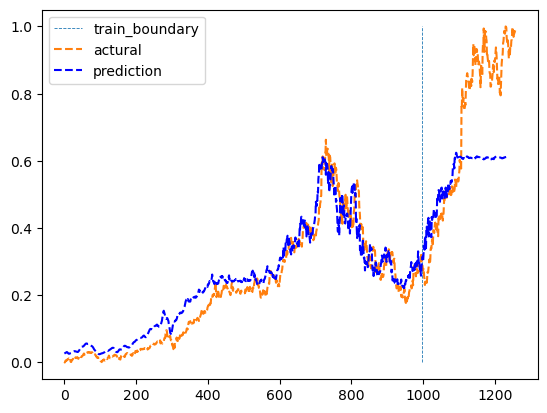

In [26]:
# visualization (plot)
with torch.no_grad():
    train_pred = []
    test_pred = []
    
    for batch_idx, (x_data, y_label) in enumerate(train_loader):
        x_data = x_data.to(device)
        label = y_label.to(device)
        y_predict = model(x_data)
        train_pred += y_predict.cpu().numpy().tolist()
        
    for batch_idx, (x_data, y_label) in enumerate(test_loader):
        x_data = x_data.to(device)
        label = y_label.to(device)
        y_predict = model(x_data)
        test_pred += y_predict.cpu().numpy().tolist()
        
total = train_pred + test_pred
plt.figure()
plt.plot(np.ones(100)*len(train_pred), np.linspace(0, 1, 100), '--', linewidth=0.6)
plt.plot(data_aapl, '--')
plt.plot(total, 'b--')
plt.legend(['train_boundary', 'actural', 'prediction'])
plt.show()